In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob

## Data cleaning

As the images I use do not have the consistent name convention, I will change it. 

In [42]:
paths = ['dataset/incorrect_mask', 'dataset/with_mask', 'dataset/without_mask']
for path in paths:
    i = 0
    for filename in os.listdir(path):
        os.rename(os.path.join(path,filename), os.path.join(path, str(i)+'.jpg'))
        i = i + 1

## Load the exemplary image

In [8]:
img_example = cv.imread('dataset/without_mask/0.jpg')
img_example1 = cv.imread('dataset/with_mask/0.jpg')

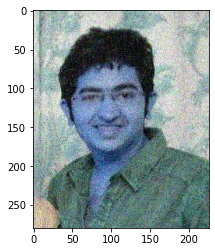

In [44]:
plt.imshow(img_example)

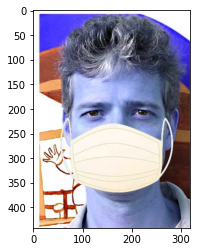

In [3]:
plt.imshow(img_example1)

As can be seen, the colors are probably swapped - matplotlib and openCV have different color channels order. Therefore, for the display purposes, I use a function that will correct the displayed image.

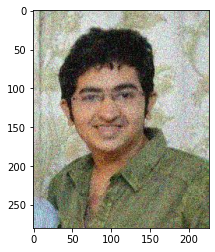

In [4]:
img_display = cv.cvtColor(img_example, cv.COLOR_BGR2RGB)
plt.imshow(img_display)

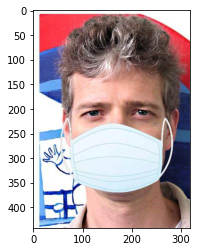

In [5]:
img_display1 = cv.cvtColor(img_example1, cv.COLOR_BGR2RGB)
plt.imshow(img_display1)

That is much better. Now I can go on and apply face detection - there is no need to look for a face mask beyond this region after all: this way, after the model detects the face, I can crop the image before giving in to the mask detection model, which will speed up its execution time.

## Face detection

For this task, I will use Cascade classifier provided by openCV, as well as their frontal face d. To actually use this, I have to convert my image to the greyscale.

In [9]:
img_gray1 = cv.cvtColor(img_example1, cv.COLOR_BGR2GRAY)
img_gray = cv.cvtColor(img_example, cv.COLOR_BGR2GRAY)

In [10]:
face_detector = cv.CascadeClassifier('dataset/haarcascade_frontalface_default.xml')

In [8]:
faces1 = face_detector.detectMultiScale(img_gray1, scaleFactor = 1.2, minNeighbors = 5)
faces = face_detector.detectMultiScale(img_gray, scaleFactor = 1.2, minNeighbors = 5)
faces

array([[ 38,  64, 118, 118]], dtype=int32)

The detector found a face and its coordinates on the image. Let's see where it lies:

In [9]:
for (a, b, c, d) in faces:
    crop_img = img_display[b:b+d, a:a+c]
    cv.rectangle(img_display, (a, b), (a+c, b+d), (0, 0, 255), 2)
for (a, b, c, d) in faces1:
    crop_img1 = img_display1[b:b+d, a:a+c]
    cv.rectangle(img_display1, (a, b), (a+c, b+d), (0, 0, 255), 2)

That should do it. Let's display the image:

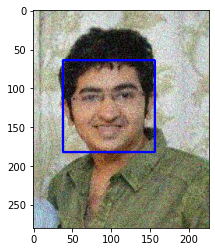

In [10]:
plt.imshow(img_display)

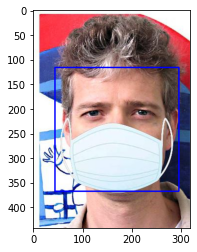

In [11]:
plt.imshow(img_display1)

I used the blue frame as it have not checked the appearance of the mask yet. Well, I can crop it already in fact. I did it for the display photos during the rectangle addition so that I wouldn't have to loop through the coordinates again.

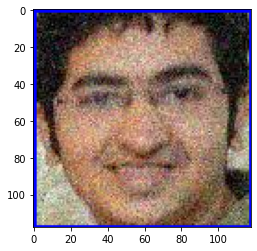

In [12]:
plt.imshow(crop_img)

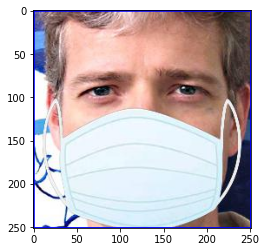

In [13]:
plt.imshow(crop_img1)

Wonderful! I now have smaller regions to take care of. However, I shall rescale them before forwarding them into the next model.

In [14]:
scale_size = (240, 240)

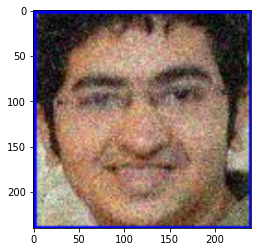

In [15]:
plt.imshow(cv.resize(crop_img, scale_size))

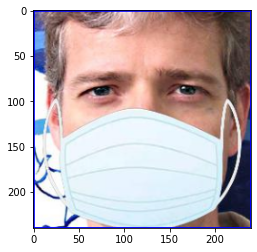

In [16]:
plt.imshow(cv.resize(crop_img1, scale_size))

To sum up this part, I can do the following before checking the mask correctness:
* load the image
* make it into the grayscale
* detect all the faces on it and save their coordinates - there will be needed for the annotations later on
* crop the image to face only - I will have to consider what to do in case of more than one on the image, but it will only be a case for user's input
* depending on the model I will use, I may have to flatten the image representation

## Prepare data

In [3]:
masked = glob.glob("dataset/with_mask/*.jpg")
img_m = [cv.imread(img) for img in masked if cv.imread(img) is not None]


In [4]:
unmasked = glob.glob("dataset/without_mask/*.jpg")
img_u = [cv.imread(img) for img in unmasked if cv.imread(img) is not None]


In [5]:
incorrect = glob.glob("dataset/incorrect_mask/*.jpg")
img_i = [cv.imread(img) for img in incorrect if cv.imread(img) is not None]

As I will create labels later on, I do not have to worry about number of cropped images.

In [101]:
def get_faces(img, model, scaleFactor, minNeighbors, dimensions=(240, 240), for_display=False):
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = model.detectMultiScale(img_gray, scaleFactor = scaleFactor, minNeighbors = minNeighbors)
    extracted = []
    coords = []
    for (a, b, c, d) in faces:
        crop_img = img_gray[b:b+d, a:a+c]
        if crop_img.size != 0 and crop_img.size != 1:
            crop_img = cv.resize(crop_img, dimensions)
            extracted.append(crop_img)
            # if for_display:
            #     coords.append([a, b, c, d])
    if len(extracted) == 0:
        return None
    if for_display:
        return extracted, faces
    return extracted

This returns list of faces found in the picture. In turn, it gives us another level of nesting for the whole dataset. This means I need to unlist the results for each image before making a list of faces.

## Test and train data

I will divide each photo set into train and test data. For the rest data, I need to preserve the display photos and the coordinates of faces in order to make annotations on it.

In [12]:
masked_train, masked_test = img_m[: int(len(img_m) * .8)], img_m[int(len(img_m) * .8):]
unmasked_train, unmasked_test = img_u[: int(len(img_u) * .8)], img_u[int(len(img_u) * .8):]
incorrect_train, incorrect_test = img_i[: int(len(img_i) * .8)], img_i[int(len(img_i) * .8):]

### Train dataset prepatations

In [82]:
mfaces = [get_faces(image, face_detector, 1.2, 5) for image in masked_train if get_faces(image, face_detector, 1.2, 5) is not None]
mfaces = [face for image in mfaces for face in image]

ufaces = [get_faces(image, face_detector, 1.2, 5) for image in unmasked_train if get_faces(image, face_detector, 1.2, 5) is not None]
ufaces = [face for image in ufaces for face in image]

ifaces = [get_faces(image, face_detector, 1.2, 5) for image in incorrect_train if get_faces(image, face_detector, 1.2, 5) is not None]
ifaces = [face for image in ifaces for face in image]

Great! Now I have three lists with face samples, that need to be labeled and fed to the model.

#### Get the labels

In [14]:
mfaces_lbl = [2]* len(mfaces)
ifaces_lbl = [1]* len(ifaces)
ufaces_lbl = [0]* len(ufaces)

#### Merge it for the model

In [74]:
x_train = mfaces + ufaces + ifaces
Y_train = mfaces_lbl + ufaces_lbl + ifaces_lbl

I flatten the training data because of the model needs.

In [85]:
X_train = (np.array(x_train)).reshape((len(Y_train), -1))

### Train data

This will be what I will be doing with the input from the user: turining photos into grayscale, finding faces on the given photos, saving the coordinates, checking for the mask on the faces and then annotating the face on the displayed photo.

In [105]:
mtest, mcoords = map(list,zip(*[get_faces(image, face_detector, 1.2, 5, for_display=True) for image in masked_test if get_faces(image, face_detector, 1.2, 5) is not None]))
mtest = [face for image in mtest for face in image]

itest, icoords = map(list,zip(*[get_faces(image, face_detector, 1.2, 5, for_display=True) for image in incorrect_test if get_faces(image, face_detector, 1.2, 5) is not None]))
itest = [face for image in itest for face in image]

utest, ucoords = map(list,zip(*[get_faces(image, face_detector, 1.2, 5, for_display=True) for image in unmasked_test if get_faces(image, face_detector, 1.2, 5) is not None]))
utest = [face for image in utest for face in image]


I found the necessary regions for exemplary presentation later on. Now I shall find the labels for the train data.

In [109]:
mtest_lbl = [2]* len(mtest)
itest_lbl = [1]* len(itest)
utest_lbl = [0]* len(utest)

In [112]:
test_coords = mcoords + ucoords + icoords

In [110]:
x_test = mtest + utest + itest
Y_test = mtest_lbl + utest_lbl + itest_lbl

In [111]:
X_test = (np.array(x_test)).reshape((len(Y_test), -1))

## Build model

I will use scikit learn SVM classifier to detect the mask or its lack.

In [27]:
from sklearn import svm